# Deep Learning Model for Algorithmic Trading of Limit Order Book Data

# Problem Statement

This project leverages deep learning techniques to uncover trading opportunities by analyzing imbalances in limit order book (LOB) data for a given security. The limit order book represents a real-time, dynamic snapshot of market supply and demand, capturing the aggregate buy (bid) and sell (ask) orders at various price levels. These orders, placed by market participants, reflect their willingness to buy or sell a security at specific prices and volumes, providing a rich source of high-frequency data for predictive modeling. The primary objective of this model is to predict short-term forward price movements by extracting and processing features from current and historical bid-ask volume imbalances derived from raw LOB data.

Limit order books are foundational to modern electronic trading systems, serving as the core mechanism for price formation in financial markets. Unlike traditional market data, such as closing prices or trading volumes, LOB data offers a granular view of market dynamics, revealing the depth and liquidity at each price level. This depth is critical for understanding market sentiment, as imbalances between bid and ask volumes can signal potential price momentum or reversals. For instance, a significant surplus of bid volume at higher price levels may indicate bullish sentiment, while an accumulation of ask volume could suggest impending downward pressure. By harnessing deep learning, this project aims to capture complex, non-linear patterns in these imbalances that are often imperceptible to traditional statistical models, enabling more accurate predictions of price movements in high-frequency trading environments.

Specifically, this project will utilize a long short-term memory (lstm) model, a specialized type of recurrent neural network. Unlike traditional RNNs, which struggle with issues like vanishing or exploding gradients during backpropagation, LSTMs address these challenges by introducing a memory cell and three key gates that regulate the flow of information. This makes LSTMs particularly well-suited for tasks involving time-series data, such as predicting price movements.

# Overview of the Data

The data for this project comes from [Lobster](https://lobsterdata.com/index.php). From their website:
>LOBSTER is an online limit order book data tool to provide easy-to-use, high-quality limit order book data.
>Since 2013 LOBSTER acts as a data provider for the academic community, giving access to reconstructed limit order book data for the entire universe of NASDAQ traded stocks."

Because of the relatively high fees associate with a full account, this project will use their freely available sample dataset.

Below is their provided overview for the format of the data and the meaning of various columns.

In [1]:
# Output Structure:
# ---------------

# LOBSTER generates a 'message' and an 'orderbook' file for each active
# trading day of a selected ticker. The 'orderbook' file contains the
# evolution of the limit order book up to the requested number of levels.
# The 'message' file contains indicators for the type of event causing
# an update of the limit order book in the requested price range. All
# events are timestamped to seconds after midnight, with decimal
# precision of at least milliseconds and up to nanoseconds depending
# on the requested period.


# 	Message File:		(Matrix of size: (Nx6))
# 	-------------

# 	Name: 	TICKER_Year-Month-Day_StartTime_EndTime_message_LEVEL.csv

# 		StartTime and EndTime give the theoretical beginning
# 		and end time of the output file in milliseconds after
# 		mid night. LEVEL refers to the number of levels of the
# 		requested limit order book.


# 	Columns:

# 	    1.) Time:
# 				Seconds after midnight with decimal
# 				precision of at least milliseconds
# 				and up to nanoseconds depending on
# 				the requested period
# 	    2.) Type:
# 				1: Submission of a new limit order
# 				2: Cancellation (Partial deletion
# 				   of a limit order)
# 				3: Deletion (Total deletion of a limit order)
# 				4: Execution of a visible limit order
# 				5: Execution of a hidden limit order
# 				7: Trading halt indicator
# 				   (Detailed information below)
# 	    3.) Order ID:
# 				Unique order reference number
# 				(Assigned in order flow)
# 	    4.) Size:
# 				Number of shares
# 	    5.) Price:
# 				Dollar price times 10000
# 				(i.e., A stock price of $91.14 is given
# 				by 911400)
# 	    6.) Direction:
# 				-1: Sell limit order
# 				1: Buy limit order

# 				Note:
# 				Execution of a sell (buy) limit
# 				order corresponds to a buyer (seller)
# 				initiated trade, i.e. Buy (Sell) trade.


# 	Orderbook File:		(Matrix of size: (Nx(4xNumberOfLevels)))
# 	---------------

# 	Name: 	TICKER_Year-Month-Day_StartTime_EndTime_orderbook_LEVEL.csv

# 	Columns:

#  	    1.) Ask Price 1: 	Level 1 Ask Price 	(Best Ask)
# 	    2.) Ask Size 1: 	Level 1 Ask Volume 	(Best Ask Volume)
# 	    3.) Bid Price 1: 	Level 1 Bid Price 	(Best Bid)
# 	    4.) Bid Size 1: 	Level 1 Bid Volume 	(Best Bid Volume)
# 	    5.) Ask Price 2: 	Level 2 Ask Price 	(2nd Best Ask)
# 	    ...

# 	Notes:
# 	------

# 		- Levels:

# 		The term level refers to occupied price levels. This implies
# 		that the difference between two levels in the LOBSTER output
# 		is not necessarily the minimum ticks size.

# 		- Unoccupied Price Levels:

# 		When the selected number of levels exceeds the number of levels
# 		available the empty order book positions are filled with dummy
# 		information to guarantee a symmetric output. The extra bid
# 		and/or ask prices are set to -9999999999 and 9999999999,
# 		respectively. The Corresponding volumes are set to 0.

# 		- Trading Halts:

# 		When trading halts, a message of type '7' is written into the
# 		'message' file. The corresponding price and trade direction
# 		are set to '-1' and all other properties are set to '0'.
# 		Should the resume of quoting be indicated by an additional
# 		message in NASDAQ's Historical TotalView-ITCH files, another
# 		message of type '7' with price '0' is added to the 'message'
# 		file. Again, the trade direction is set to '-1' and all other
# 		fields are set to '0'.
# 		When trading resumes a message of type '7' and
# 		price '1' (Trade direction '-1' and all other
# 		entries '0') is written to the 'message' file. For messages
# 		of type '7', the corresponding order book rows contain a
# 		duplication of the preceding order book state. The reason
# 		for the trading halt is not included in the output.

# 			Example: Stylized trading halt messages in 'message' file.

# 			Halt: 				36023	| 7 | 0 | 0 | -1 | -1
# 											...
# 			Quoting: 			36323 	| 7 | 0 | 0 | 0  | -1
# 											...
# 			Resume Trading:		36723   | 7 | 0 | 0 | 1  | -1
# 											...

# 			The vertical bars indicate the different columns in the
# 			message file.

# =========================================================================

In [64]:
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os

from scipy.stats import expon
from collections import Counter

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import keras_tuner as kt
import seaborn as sns


np.random.seed(0)
tf.random.set_seed(0) # Set seed for reproducibility in TensorFlow/Keras

In [3]:
# Stock name
ticker = 'INTC'
# Levels
lvl = 10

data_dir = '.' # Current directory
nameBook    = os.path.join(data_dir, f'{ticker}_2012-06-21_34200000_57600000_orderbook_{lvl}.csv')
nameMess    = os.path.join(data_dir, f'{ticker}_2012-06-21_34200000_57600000_message_{lvl}.csv')

# Date of files
demo_date = datetime.date(2012, 6, 21)

In [4]:
# Trading hours (start & end)
startTrad   = 9.5 * 60 * 60       # 9:30:00 in sec after midnight
endTrad     = 16 * 60 * 60        # 16:00:00 in sec after midnight

In [5]:
try:
    mess = np.loadtxt(nameMess, delimiter=',')
except FileNotFoundError:
    print(f"Error: Message file not found at {nameMess}")
    print("Please make sure the data file is in the correct directory.")
    exit()
except Exception as e:
    print(f"Error loading message file: {e}")
    exit()

In [6]:
try:
    book = np.loadtxt(nameBook, delimiter=',')
except FileNotFoundError:
    print(f"Error: Orderbook file not found at {nameBook}")
    print("Please make sure the data file is in the correct directory.")
    exit()
except Exception as e:
    print(f"Error loading orderbook file: {e}")
    exit()

In [7]:
print(mess.shape)
print(book.shape)

(624040, 6)
(624040, 40)


In [8]:
# Column 0 contains the time stamp
timeIdx = (mess[:, 0] >= startTrad) & (mess[:, 0] <= endTrad)

mess = mess[timeIdx, :]
book = book[timeIdx, :]

In [9]:
# Check for trading halts
tradeHaltIdx = np.where(mess[:, 1] == 7)[0] # np.where returns a tuple, get the first element
if tradeHaltIdx.size > 0:
    print(f"Data contains trading halt! Indices in tradeHaltIdx: {tradeHaltIdx}")
else:
	print('No trading halts detected.')

No trading halts detected.


# Exploratory Data Analysis (EDA)

In [10]:
freq = 1 * 60   # Interval length in sec
bounds = np.arange(startTrad, endTrad + freq, freq)

bl = len(bounds)

# The slice mess[boundIdx[k]:boundIdx[k+1]] will contain events in the k-th interval.
boundIdx = np.searchsorted(mess[:, 0], bounds, side='left')

In [11]:
# Plot - Number of Executions and Trade Volume by Interval

tradesInfo = np.zeros((bl - 1, 4))

for k1 in range(bl - 1): # Iterate through intervals 0 to bl-2

    # Get intraday mess window for the interval
    # Slice uses start index boundIdx[k1] and end index boundIdx[k1+1]
    # Select columns 1 (event type) and 3 (size)
    start_idx = boundIdx[k1]
    end_idx = boundIdx[k1 + 1]
    temp = mess[start_idx:end_idx, [1, 3]]

    # Visible executions (type 4)
    tempVis_idx = (temp[:, 0] == 4)
    tempVis_sizes = temp[tempVis_idx, 1]

    # Hidden executions (type 5)
    tempHid_idx = (temp[:, 0] == 5)
    tempHid_sizes = temp[tempHid_idx, 1]

    tradesInfo[k1, 0] = tempVis_sizes.shape[0] # Number of visible executions
    tradesInfo[k1, 1] = np.sum(tempVis_sizes)  # Volume of visible executions
    tradesInfo[k1, 2] = tempHid_sizes.shape[0] # Number of hidden executions
    tradesInfo[k1, 3] = np.sum(tempHid_sizes)  # Volume of hidden executions


interval_labels = [f"{int(b/3600):02d}:{int((b%3600)/60):02d}" for b in bounds[:-1]]

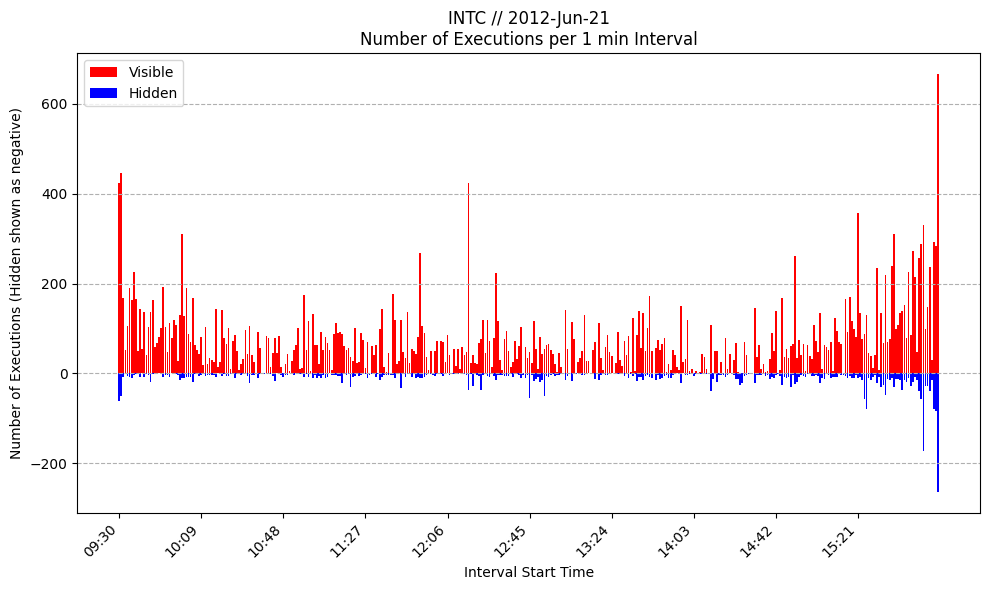

In [12]:
# Plot number of executions
plt.figure(figsize=(10, 6), facecolor='white')

bar_width = 0.8
interval_indices = np.arange(bl - 1)

plt.bar(interval_indices, tradesInfo[:, 0], bar_width, color='red', label='Visible')
plt.bar(interval_indices, -tradesInfo[:, 2], bar_width, color='blue', label='Hidden')

plt.title(f"{ticker} // {demo_date.strftime('%Y-%b-%d')}\n"
          f"Number of Executions per {freq // 60} min Interval")
plt.xlabel('Interval Start Time')
plt.ylabel('Number of Executions (Hidden shown as negative)')
plt.xticks(interval_indices[::max(1, len(interval_indices)//10)],
           interval_labels[::max(1, len(interval_indices)//10)],
           rotation=45, ha='right')
plt.legend(loc='upper left')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

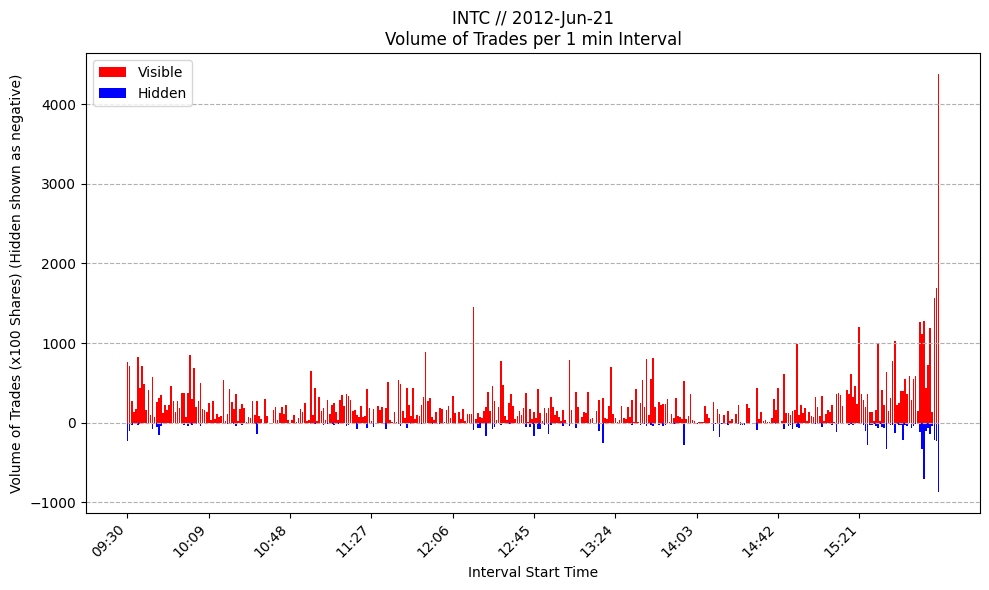

In [13]:
# Plot volume of trades
plt.figure(figsize=(10, 6), facecolor='white')
plt.bar(interval_indices, tradesInfo[:, 1] / 100.0, bar_width, color='red', label='Visible')
plt.bar(interval_indices, -tradesInfo[:, 3] / 100.0, bar_width, color='blue', label='Hidden')

plt.title(f"{ticker} // {demo_date.strftime('%Y-%b-%d')}\n"
          f"Volume of Trades per {freq // 60} min Interval")
plt.xlabel('Interval Start Time')
plt.ylabel('Volume of Trades (x100 Shares) (Hidden shown as negative)')
plt.xticks(interval_indices[::max(1, len(interval_indices)//10)],
           interval_labels[::max(1, len(interval_indices)//10)],
           rotation=45, ha='right')
plt.legend(loc='upper left')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

As expected, the number of trades that took place and the volume of shares traded graphs look roughly similar. Both graphs display long periods of calm interspersed with high bursts of activity.

Now lets visualize a snapshot of the limit order book.

In [14]:
# Convert prices into dollars
# Prices are in columns 0, 2, 4, 6, ... up to 4*lvl - 2
price_cols = np.arange(0, 4 * lvl, 2)
book[:, price_cols] = book[:, price_cols] / 10000.0 # Note: LOBSTER stores prices in dollar price times 10000

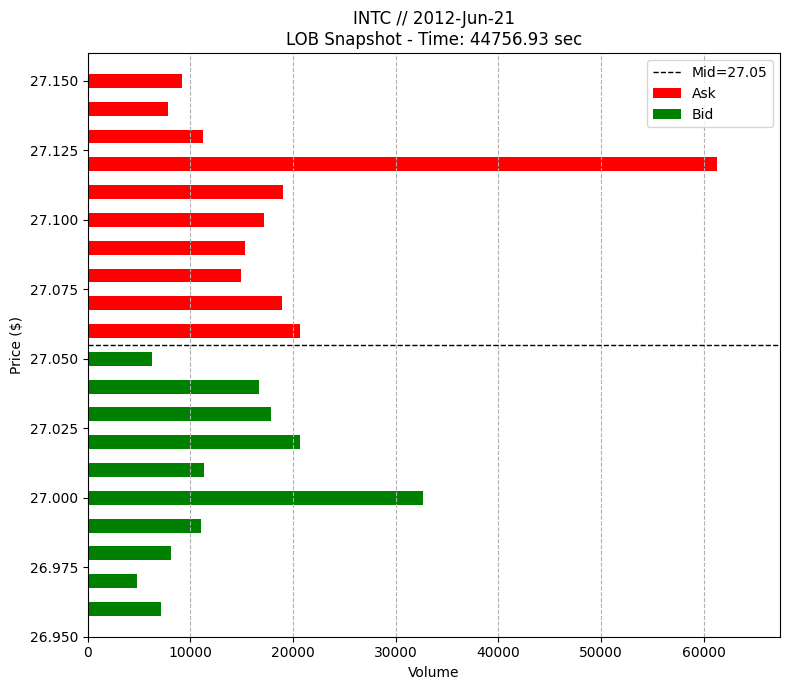

In [15]:
# Plot - Snapshot of the Limit Order Book
eventIdx = np.random.randint(0, book.shape[0]) # Pick a random row/event index

# Postions of variables in the book
askPricePos = np.arange(0, 4 * lvl, 4)       # 0, 4, 8, ...
askVolPos   = askPricePos + 1                # 1, 5, 9, ...
bidPricePos = askPricePos + 2                # 2, 6, 10, ...
bidVolPos   = bidPricePos + 1                # 3, 7, 11, ...

# Get the specific row from the book
book_event = book[eventIdx, :]
event_time = mess[eventIdx, 0]

# Extract ask/bid prices and volumes for the selected event
ask_prices = book_event[askPricePos]
ask_volumes = book_event[askVolPos]
bid_prices = book_event[bidPricePos]
bid_volumes = book_event[bidVolPos]

# Filter out invalid price levels
valid_asks = ask_prices < 999999999
valid_bids = bid_prices > 0

ask_prices = ask_prices[valid_asks]
ask_volumes = ask_volumes[valid_asks]
bid_prices = bid_prices[valid_bids]
bid_volumes = bid_volumes[valid_bids]

if ask_prices.size > 0 and bid_prices.size > 0:
  # Price
  maxPrice = np.max(ask_prices) + 0.01
  minPrice = np.min(bid_prices) - 0.01

  # Volume
  maxVol = np.max(np.concatenate((ask_volumes, bid_volumes))) * 1.1

  # Mid quote
  mid = 0.5 * (ask_prices[0] + bid_prices[0])

  # Plot
  plt.figure(figsize=(8, 7), facecolor='white')
  plt.barh(ask_prices, ask_volumes, color='red', label='Ask', height=0.005)
  plt.barh(bid_prices, bid_volumes, color='green', label='Bid', height=0.005)
  plt.axhline(y=mid, color='k', linestyle='--', linewidth=1, label=f'Mid={mid:.2f}')

  plt.title(f"{ticker} // {demo_date.strftime('%Y-%b-%d')}\n"
            f"LOB Snapshot - Time: {event_time:.2f} sec")
  plt.ylabel('Price ($)')
  plt.xlabel('Volume')
  plt.ylim(minPrice, maxPrice)
  plt.xlim(0, maxVol)
  plt.legend(loc='best')
  plt.grid(axis='x', linestyle='--')
  plt.tight_layout()
  plt.show()

Another way this can be visualized is with a step plot where the x axis is depth level and the y axis is the cumulative percentage of volume through that level.

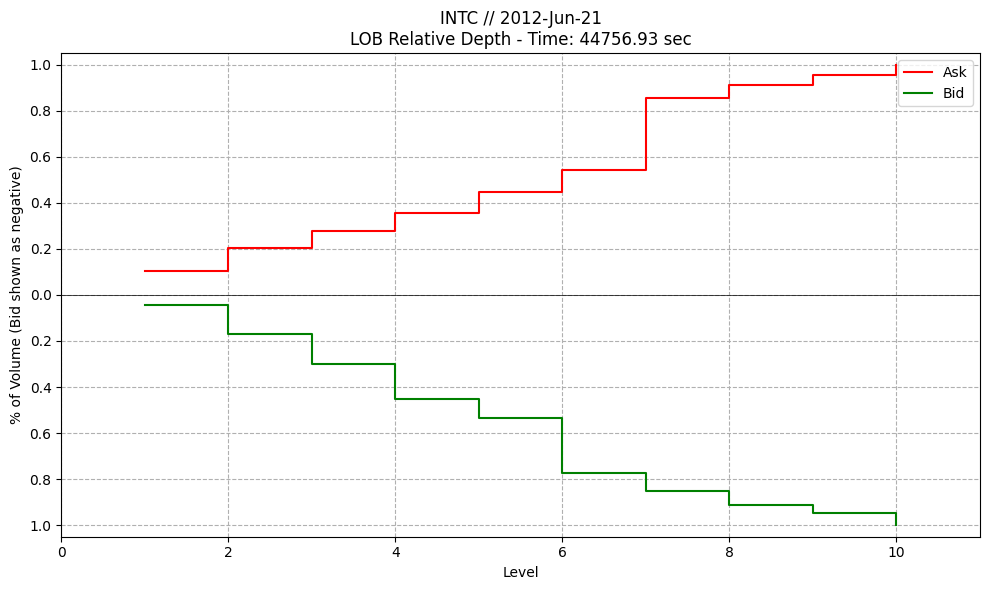

In [16]:
if ask_prices.size > 0 and bid_prices.size > 0:
  # Relative volume
  book_event_volumes_ask = book_event[askVolPos][:len(ask_prices)]
  book_event_volumes_bid = book_event[bidVolPos][:len(bid_prices)]

  # Ask (cumulative sum)
  bookVolAsk = np.cumsum(book_event_volumes_ask)
  if bookVolAsk[-1] > 0:
      bookVolAsk = bookVolAsk / bookVolAsk[-1]
  else:
      bookVolAsk = np.zeros_like(bookVolAsk)

  # Bid (cumulative sum)
  bookVolBid = np.cumsum(book_event_volumes_bid)
  if bookVolBid[-1] > 0:
      bookVolBid = bookVolBid / bookVolBid[-1]
  else:
      bookVolBid = np.zeros_like(bookVolBid)

  levels_ask = np.arange(1, len(ask_prices) + 1)
  levels_bid = np.arange(1, len(bid_prices) + 1)

  # Plot
  plt.figure(figsize=(10, 6), facecolor='white')
  plt.step(levels_ask, bookVolAsk, where='post', linewidth=1.5, color='red', label='Ask') # Red for asks
  plt.step(levels_bid, -bookVolBid, where='post', linewidth=1.5, color='green', label='Bid') # Green for bids

  plt.title(f"{ticker} // {demo_date.strftime('%Y-%b-%d')}\n"
            f"LOB Relative Depth - Time: {event_time:.2f} sec")
  plt.ylabel('% of Volume (Bid shown as negative)')
  plt.xlabel('Level')
  plt.xlim(0, lvl + 1)
  plt.ylim(-1.05, 1.05)
  plt.axhline(0, color='black', linewidth=0.5) # Zero line
  plt.yticks(np.linspace(-1, 1, 11),
              [f'{abs(x):.1f}' for x in np.linspace(-1, 1, 11)]) # Labels as positive percentages
  plt.legend(loc='best')
  plt.grid(axis='both', linestyle='--')
  plt.tight_layout()
  plt.show()

Now lets look at order book evolution over the day.

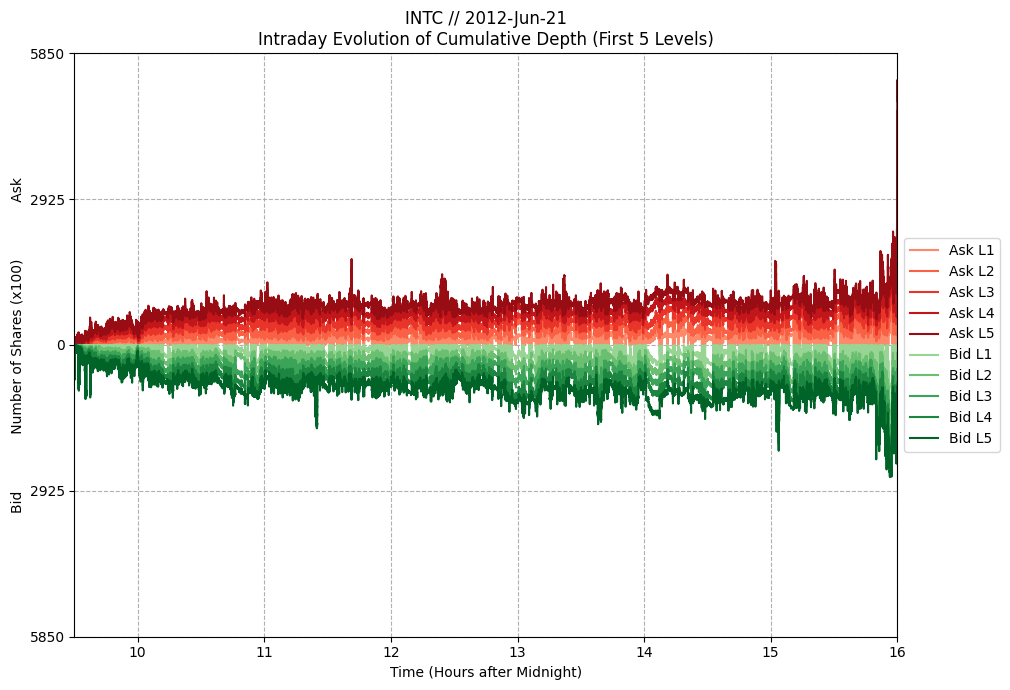

In [17]:
#Plot - Intraday Evolution of Depth

# Display only the first 'maxLvl' levels. Graph gets fairly messy if using the full depth
maxLvl = 5

if maxLvl <= lvl:
  askVolPos_depth = np.arange(1, 4 * maxLvl, 4) # Indices 1, 5, 9, ...
  bidVolPos_depth = np.arange(3, 4 * maxLvl, 4) # Indices 3, 7, 11, ...

  bookVolAsk_ts = np.cumsum(book[:, askVolPos_depth] / 100.0, axis=1)
  bookVolBid_ts = np.cumsum(book[:, bidVolPos_depth] / 100.0, axis=1)

  # Max depth for plot limits
  max_ask_depth = np.max(bookVolAsk_ts[:, -1]) if bookVolAsk_ts.shape[0] > 0 else 0
  max_bid_depth = np.max(bookVolBid_ts[:, -1]) if bookVolBid_ts.shape[0] > 0 else 0
  maxVol_depth = np.max([max_ask_depth, max_bid_depth])
  maxVol_plot = np.ceil(maxVol_depth * 1.1 / 10) * 10

  # Time axis in hours
  time_hours = mess[:, 0] / (60 * 60)

  # Plot
  plt.figure(figsize=(12, 7), facecolor='white')

  colors_ask = plt.cm.Reds(np.linspace(0.4, 0.9, maxLvl)) # Color gradient for asks
  colors_bid = plt.cm.Greens(np.linspace(0.4, 0.9, maxLvl)) # Color gradient for bids

  for i in range(maxLvl):
      plt.plot(time_hours, bookVolAsk_ts[:, i], label=f'Ask L{i+1}', color=colors_ask[i])

  for i in range(maxLvl):
      plt.plot(time_hours, -bookVolBid_ts[:, i], label=f'Bid L{i+1}', color=colors_bid[i])

  plt.title(f"{ticker} // {demo_date.strftime('%Y-%b-%d')}\n"
            f"Intraday Evolution of Cumulative Depth (First {maxLvl} Levels)")
  plt.ylim(-maxVol_plot, maxVol_plot)
  plt.xlim(9.5, 16.0)
  plt.xlabel('Time (Hours after Midnight)')
  plt.ylabel(f"{'Bid':<15} Number of Shares (x100) {'Ask':>15}")

  # Custom Y-axis ticks and labels
  tick_values = np.linspace(-maxVol_plot, maxVol_plot, 5)
  tick_labels = [f"{abs(int(v))}" for v in tick_values]
  tick_labels[len(tick_labels)//2] = "0"
  plt.yticks(tick_values, tick_labels)

  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.grid(True, linestyle='--')
  plt.tight_layout(rect=[0, 0, 0.85, 1])
  plt.show()

# Preprocessing

Now we will merge the files and create a dictionary to help remember the ordering of the columns for processing.

In [18]:
merged = np.hstack((mess, book))

In [19]:
# Col Index Reminder
col_dict = {
    0: 'Time',
    1: 'Type',
    2: 'Order ID',
    3: 'Size',
    4: 'Price',
    5: 'Direction',
    6: 'Ask Price 1',
    7: 'Ask Size 1',
    8: 'Bid Price 1',
    9: 'Bid Size 1',
    10: 'Ask Price 2',
    11: 'Ask Size 2',
    12: 'Bid Price 2',
    13: 'Bid Size 2',
    14: 'Ask Price 3',
    15: 'Ask Size 3',
    16: 'Bid Price 3',
    17: 'Bid Size 3',
    18: 'Ask Price 4',
    19: 'Ask Size 4',
    20: 'Bid Price 4',
    21: 'Bid Size 4',
    22: 'Ask Price 5',
    23: 'Ask Size 5',
    24: 'Bid Price 5',
    25: 'Bid Size 5',
    26: 'Ask Price 6',
    27: 'Ask Size 6',
    28: 'Bid Price 6',
    29: 'Bid Size 6',
    30: 'Ask Price 7',
    31: 'Ask Size 7',
    32: 'Bid Price 7',
    33: 'Bid Size 7',
    34: 'Ask Price 8',
    35: 'Ask Size 8',
    36: 'Bid Price 8',
    37: 'Bid Size 8',
    38: 'Ask Price 9',
    39: 'Ask Size 9',
    40: 'Bid Price 9',
    41: 'Bid Size 9',
    42: 'Ask Price 10',
    43: 'Ask Size 10',
    44: 'Bid Price 10',
    45: 'Bid Size 10'
}

Double check to make sure the column values match our expectations.

In [20]:
for i,val in enumerate(merged[0]):
  print(col_dict[i], val)

Time 34200.005742728
Type 4.0
Order ID 15835012.0
Size 34.0
Price 275200.0
Direction -1.0
Ask Price 1 27.52
Ask Size 1 66.0
Bid Price 1 27.51
Bid Size 1 400.0
Ask Price 2 27.53
Ask Size 2 1000.0
Bid Price 2 27.5
Bid Size 2 100.0
Ask Price 3 27.54
Ask Size 3 373.0
Bid Price 3 27.49
Bid Size 3 200.0
Ask Price 4 27.56
Ask Size 4 100.0
Bid Price 4 27.48
Bid Size 4 661.0
Ask Price 5 27.57
Ask Size 5 100.0
Bid Price 5 27.47
Bid Size 5 300.0
Ask Price 6 27.59
Ask Size 6 8589.0
Bid Price 6 27.46
Bid Size 6 700.0
Ask Price 7 27.6
Ask Size 7 959.0
Bid Price 7 27.45
Bid Size 7 900.0
Ask Price 8 27.61
Ask Size 8 2300.0
Bid Price 8 27.44
Bid Size 8 2800.0
Ask Price 9 27.62
Ask Size 9 2700.0
Bid Price 9 27.43
Bid Size 9 3300.0
Ask Price 10 27.63
Ask Size 10 2000.0
Bid Price 10 27.42
Bid Size 10 4063.0


# Define "Trading Strategy" for the Model

For this study, I will make a few assumptions about the trading model:
- All cash is invested when the model predicts positive price movements
- All cash is taken out when the model predicts negative movements.
- There are no transaction costs
- The model's actions have no affect on any future prices
- The risk-free rate is 0% i.e. we earn no money sitting in cash.


# Create Model Features

A common order book feature is called the imbalance index$^1.$ This is calculated as the ratio of weighted averages of the top n levels of volume on either side of the midpoint at some time t.

$$I_t = \frac{V_{bt}-V_{at}}{V_{bt}+V_{at}}$$

and

$$V_{bt} = \sum_{j=1}^{n}e^{-λ(j-1)}V_{jt}$$

where $V_{jt}$ is the level $j$ bid volume at time $t$

A positive value indicates a larger bid volume than ask volume and a negative value indicates a larger ask volume than bid volume.
<br></br>

1 Rubisov, Anton D. "Statistical Arbitrage Using Limit Order Book Imbalance." Master's thesis, University of Toronto, 2015.

In [21]:
# Hyperparameters
lvl = 10
_lambda = 0.5

# Create the weights vector (with indices 0 to lvl-1)
weights = np.exp(-_lambda * np.arange(lvl))

# Ask Size 1 -> index 7, Ask Size 2 -> index 11...
ask_columns = np.arange(7,7+(lvl*4),4)
VAsk = merged[:, ask_columns].dot(weights)

# Bid Size 1 -> index 9, Bid Size 2 -> index 13...
bid_columns = np.arange(9,9+(lvl*4),4)
VBid = merged[:, bid_columns].dot(weights)

# Compute the imbalance I for each row
# It is the normalized difference of VBid and VAsk
I = (VBid - VAsk) / (VBid + VAsk)

print("Imbalance I computed for each row:")
print(I)

Imbalance I computed for each row:
[-0.26315259 -0.28896874 -0.18732369 ... -0.54747135 -0.54760479
 -0.56514269]


In [22]:
# Append Imbalance as new column feature and update dict to track new column
col_dict[46] = 'Imbalance'
merged = np.column_stack((merged, I))

The second feature we will add is simply the midprice, i.e the average price between the best bid and best ask prices

In [23]:
mid = 0.5 * (merged[:, 8] + merged[:, 6])
merged = np.column_stack((merged, mid))
col_dict[47] = 'Mid'

To help narrow the scope we are going to focus on messages where an order actually executed (Type 4 or 5). This will help us capture actual trading activity and improve robustness to any malicious or spoofed limit orders. (This is less relevant on regulated exchanges, but in markets like cryptocurrencies, this can play a much larger role as adversarial algorithms opperate freely)

In [24]:
merged = merged[(merged[:, 1] == 4) | (merged[:, 1] == 5)]
print(len(merged))

32483


One thing we will also have to do for this dataset to maintain the time series nature for analysis is deduplicate the timestamps. To do this I will add an increasing number of nanoseconds to enforce uniqueness.

In [25]:
merged[:,0] = merged[:,0] + np.arange(1, len(merged) + 1) / 1e9

In many market microstructure models, order arrivals are assumed to follow a Poisson process, meaning the time between orders (interarrival times) is exponentially distributed. By fitting an exponential to these dt values we can estimate how frequently orders arrive and subsequently use this as a baseline value for the lag when comparing midprice changes.

In [26]:
dt = np.diff(merged[:, 0])
loc, scale = expon.fit(dt, floc=0)
dtav = scale  # The scale parameter is the mean of the exponential distribution
print(f"Average interarrival time (Δts): {dtav:.4f} seconds")

Average interarrival time (Δts): 0.7204 seconds


When we set the $Δt_s$ parameter it will be in intervals of 0.72 seconds on average i.e. $Δt_s=1$ corresponds to 0.72 seconds on average

In [27]:
dts = 1

In [28]:
mids = merged[:,47]
shifts = np.sign(mids[dts:]-mids[:-dts])
merged = merged[:-dts]
merged = np.column_stack((merged, shifts))
col_dict[48] = 'Shift'

Let's quickly check the distribution of our response variable. If we have too high a concentration, say 80% of the time there is no change, then a model could learn to always return no change and score well but that would have no real world use to us.

In [29]:
unique_values, counts = np.unique(merged[:,48], return_counts=True)
percentages = counts / len(merged[:,48]) * 100

print("Unique Values:", unique_values)
print("Counts:", counts)
print("Percentages:", percentages)

Unique Values: [-1.  0.  1.]
Counts: [ 1497 29651  1334]
Percentages: [ 4.60870636 91.28440367  4.10688997]


We can see from the percentages that the no change class dominates the distribution. We will first build a naieve model that does not account for this, then subsequently see how hyperparameter choices can improve performance.

# Building the Model

For this analysis I wll use a Long Short-term Memory neural network. Long Short-Term Memory (LSTM) models are a type of Recurrent Neural Network (RNN) designed to capture long-range dependencies in sequential data. Unlike traditional RNNs, LSTMs use memory cells and gating mechanisms to control the flow of information, making them effective at preserving context over many time steps. This structure helps prevent issues like vanishing or exploding gradients during training. LSTMs are especially powerful in applications involving time series forecasting, making them a good fit for this order book data.

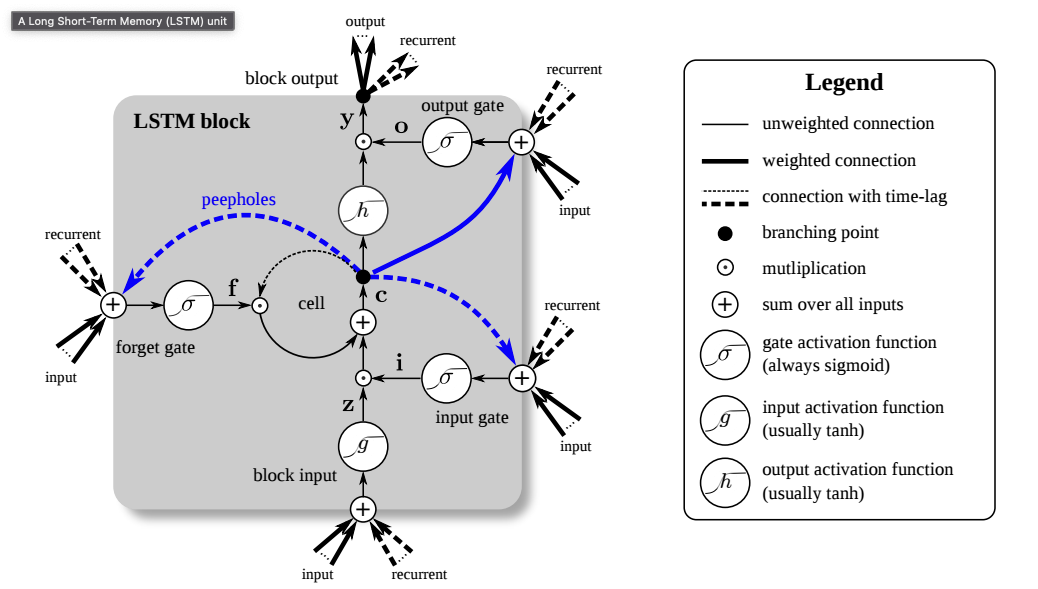

Source: https://developer.nvidia.com/discover/lstm

### Select Features and Target

In [30]:
# We will use Imbalance, and Mid-price
feature_names = ['Imbalance', 'Mid']
feature_cols = []
target_col_name = 'Shift'

# Find column indices
for name in feature_names:
    if name in col_dict.values():
        feature_cols.append(list(col_dict.keys())[list(col_dict.values()).index(name)])
    else:
        print(f"Warning: Feature '{name}' not found in col_dict. Skipping this feature.")

if target_col_name in col_dict.values():
    target_col = list(col_dict.keys())[list(col_dict.values()).index(target_col_name)]
else:
     print(f"Error: Target column '{target_col_name}' not found in col_dict.")
     exit()

if not feature_cols:
    print("Error: No valid features selected or found. Cannot build model.")
    exit()

print(f"\nSelected features: {[col_dict[c] for c in feature_cols]}")
print(f"Selected target: {col_dict[target_col]}")

features = merged[:, feature_cols].astype(np.float32)
target = merged[:, target_col].astype(np.float32)


Selected features: ['Imbalance', 'Mid']
Selected target: Shift


In [31]:
# Handle potential NaNs/Infs in features before scaling
if np.any(np.isnan(features)) or np.any(np.isinf(features)):
    print("Warning: NaNs or Infs detected in features. Replacing with column means.")
    col_means = np.nanmean(features, axis=0)
    # Find where NaNs and Infs are
    inds_nan = np.where(np.isnan(features))
    inds_inf = np.where(np.isinf(features))
    # Replace NaNs with the mean of their respective column
    features[inds_nan] = np.take(col_means, inds_nan[1])
    features[inds_inf] = np.take(col_means, inds_inf[1])
    # Check if any NaNs/Infs remain (e.g., if a whole column was NaN)
    if np.any(np.isnan(features)) or np.any(np.isinf(features)):
         print("Warning: NaNs/Infs still present after replacement. Replacing remaining with 0.")
         features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)

In [32]:
# Map target variable {-1, 0, 1} to {0, 1, 2} for classification
target_int = np.round(target).astype(int)
target_mapped = target_int + 1
unique_mapped = np.unique(target_mapped)
num_classes = len(unique_mapped)
print(f"\nTarget variable mapped to {{0, 1, 2}}. Unique values found: {unique_mapped}. Number of classes: {num_classes}")


Target variable mapped to {0, 1, 2}. Unique values found: [0 1 2]. Number of classes: 3


**Define Sequence Length (lookback window)**

In [33]:
seq_len = 100  # Hyperparameter: How many past events to look at for each prediction
print(f"Using sequence length (lookback window) = {seq_len} events.")

Using sequence length (lookback window) = 100 events.


**Scale Features**

In [34]:
scaler = MinMaxScaler()
# split point for chronological split
split_ratio = 0.8
split_idx_data = int(len(features) * split_ratio)

scaler.fit(features[:split_idx_data])

# Scale the entire feature set
features_scaled = scaler.transform(features)
print("Features scaled using MinMaxScaler (fit on training data portion).")

Features scaled using MinMaxScaler (fit on training data portion).


In [35]:
# Function to create sequences of shape (n_samples, seq_len, n_features)
def create_sequences(features, target, seq_len):
  X, y = [], []
  # Start loop from seq_len to have enough history for the first sequence
  # Iterate up to len(features) - 1 because target[i] corresponds to features[i-seq_len : i]
  for i in range(seq_len, len(features)):
      X.append(features[i-seq_len : i])
      y.append(target[i])
  if not X: # Handle case where data is shorter than seq_len
      return np.array([]), np.array([])
  return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(features_scaled, target_mapped, seq_len)

print(f"Created sequences. X shape: {X_seq.shape}, y shape: {y_seq.shape}")

Created sequences. X shape: (32382, 100, 2), y shape: (32382,)


In [36]:
# Chronological Train/Test Split
split_idx_seq = int(X_seq.shape[0] * split_ratio)

X_train, X_test = X_seq[:split_idx_seq], X_seq[split_idx_seq:]
y_train, y_test = y_seq[:split_idx_seq], y_seq[split_idx_seq:]

print(f"Chronological split: {len(X_train)} train sequences, {len(X_test)} test sequences.")

Chronological split: 25905 train sequences, 6477 test sequences.


In [37]:
# LSTM Model
n_features = X_train.shape[2] # Number of features per time step

model = Sequential([
    Input(shape=(seq_len, n_features)),          # Define input shape explicitly
    LSTM(units=64, return_sequences=True),       # First LSTM layer
    Dropout(0.3),                                # dropout
    LSTM(units=32, return_sequences=False),      # Second LSTM layer
    Dropout(0.3),                                # dropout
    Dense(units=16, activation='relu'),          # Small intermediate dense layer
    Dropout(0.3),                                # Dropout before output layer
    Dense(units=num_classes, activation='softmax') # Output layer for classification
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Adam optimizer with learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 64)        │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,147 (117.76 KB)

 Trainable params: 30,147 (117.76 KB)

 Non-trainable params: 0 (0.00 B)

**Model Training**

In [38]:
batch_size = 128
epochs = 100

In [39]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', # Monitor validation accuracy
                               patience=10,        # Stop after 10 epochs with no improvement in val_accuracy
                               mode='max',         # We want to maximize accuracy
                               restore_best_weights=True, # Restore weights from the best epoch based on val_accuracy
                               verbose=1)

print("\nStarting model training...")

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping],
                    verbose=2)

print("Model training finished.")


Starting model training...
Epoch 1/100
203/203 - 7s - 36ms/step - accuracy: 0.8916 - loss: 0.4733 - val_accuracy: 0.9583 - val_loss: 0.2079
Epoch 2/100
203/203 - 7s - 37ms/step - accuracy: 0.9024 - loss: 0.4166 - val_accuracy: 0.9583 - val_loss: 0.2020
Epoch 3/100
203/203 - 3s - 16ms/step - accuracy: 0.9024 - loss: 0.4062 - val_accuracy: 0.9583 - val_loss: 0.2006
Epoch 4/100
203/203 - 4s - 21ms/step - accuracy: 0.9024 - loss: 0.3901 - val_accuracy: 0.9583 - val_loss: 0.2049
Epoch 5/100
203/203 - 2s - 12ms/step - accuracy: 0.9024 - loss: 0.3791 - val_accuracy: 0.9583 - val_loss: 0.2084
Epoch 6/100
203/203 - 3s - 13ms/step - accuracy: 0.9024 - loss: 0.3729 - val_accuracy: 0.9583 - val_loss: 0.2066
Epoch 7/100
203/203 - 3s - 15ms/step - accuracy: 0.9024 - loss: 0.3652 - val_accuracy: 0.9583 - val_loss: 0.2046
Epoch 8/100
203/203 - 2s - 12ms/step - accuracy: 0.9024 - loss: 0.3610 - val_accuracy: 0.9583 - val_loss: 0.2029
Epoch 9/100
203/203 - 2s - 12ms/step - accuracy: 0.9024 - loss: 0.35

In [40]:
# Evaluate the Model
print("\nEvaluate model on test data...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")


Evaluating model on test data...
Test Loss: 0.2079
Test Accuracy: 0.9583 (95.83%)


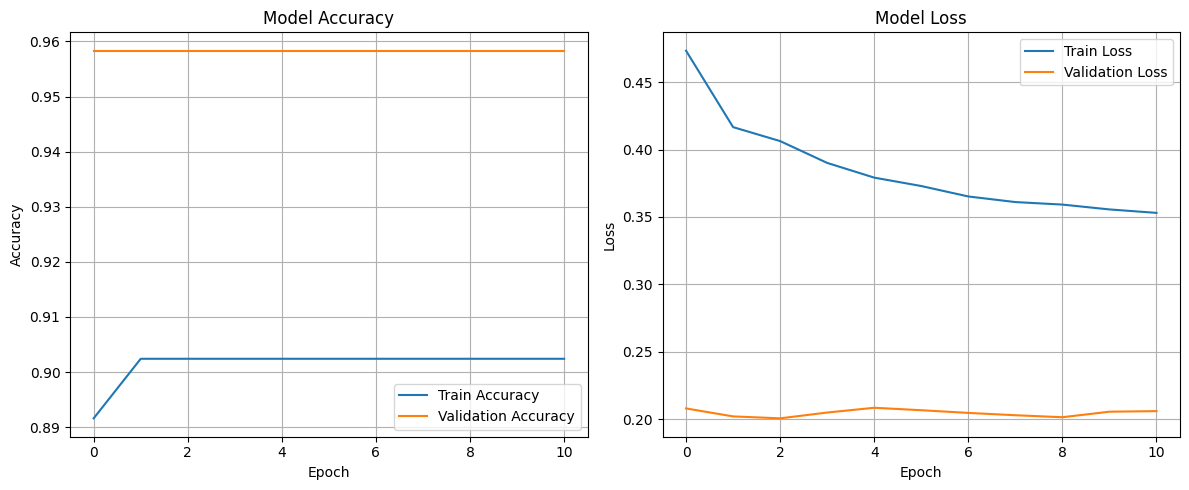

In [41]:
# Plot training history
if history and history.history:
  plt.figure(figsize=(12, 5))

  # Accuracy Plot
  plt.subplot(1, 2, 1)
  if 'accuracy' in history.history:
      plt.plot(history.history['accuracy'], label='Train Accuracy')
  if 'val_accuracy' in history.history:
      plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)

  # Loss Plot
  plt.subplot(1, 2, 2)
  if 'loss' in history.history:
    plt.plot(history.history['loss'], label='Train Loss')
  if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()
else:
  print("Could not plot training history (history object missing or empty).")

In [42]:
# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [43]:
# Classification Report
target_names = ['Down (0)', 'No Change (1)', 'Up (2)']
# Ensure labels used match the unique values in y_test and y_pred
report_labels = np.unique(np.concatenate((y_test, y_pred)))
report_target_names = [target_names[i] for i in report_labels if i < len(target_names)]

print("\nClassification Report:")
print(classification_report(y_test, y_pred, labels=report_labels, target_names=report_target_names, zero_division=0))


Classification Report:
               precision    recall  f1-score   support

     Down (0)       0.00      0.00      0.00       135
No Change (1)       0.96      1.00      0.98      6207
       Up (2)       0.00      0.00      0.00       135

     accuracy                           0.96      6477
    macro avg       0.32      0.33      0.33      6477
 weighted avg       0.92      0.96      0.94      6477




Confusion Matrix:


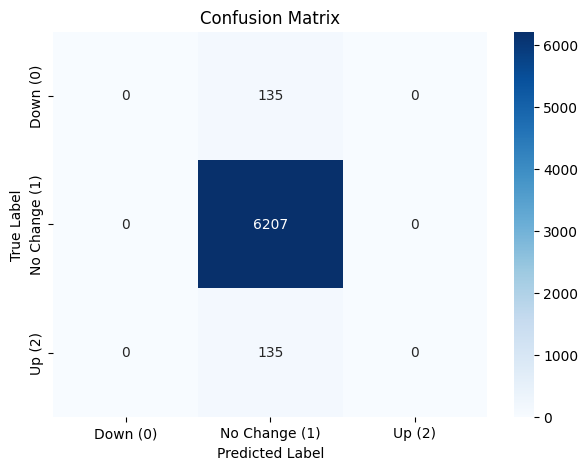

In [44]:
# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=report_labels)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=report_target_names,
            yticklabels=report_target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

As expected, without any modifications to the standard LSTM architecture we end up with a model that just defaults to predicting the no change label (i.e. the majority in the dataset). Lets see if we can hyperparameter tune our way out of this.

In [66]:
def build_model(hp):
    num_classes = len(np.unique(y_train))

    model = Sequential()
    model.add(
        LSTM(
            units=hp.Int("units", 32, 128, step=32),
            input_shape=X_train.shape[1:],
            return_sequences=False,
        )
    )
    model.add(Dropout(rate=hp.Float("dropout", 0.0, 0.5, step=0.1)))
    model.add(Dense(num_classes, activation="softmax"))

    lr = hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='hyperparam_tuning',
    project_name='lob_lstm')

tuner.search(X_train, y_train,
             epochs=20,
             validation_split=0.2,
             callbacks=[EarlyStopping(monitor='val_accuracy', patience=5)],
             verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters -> units: {best_hps.get('units')}, "
      f"dropout: {best_hps.get('dropout')}, "
      f"learning_rate: {best_hps.get('learning_rate')}")

best_model = tuner.get_best_models(num_models=1)[0]
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Best model test accuracy: {test_acc:.4f}")

Trial 10 Complete [00h 00m 58s]
val_accuracy: 0.942868173122406

Best val_accuracy So Far: 0.942868173122406
Total elapsed time: 00h 07m 03s
Best hyperparameters -> units: 64, dropout: 0.30000000000000004, learning_rate: 0.001


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best model test accuracy: 0.9583


In [67]:
y_pred_prob = best_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [68]:
# Classification Report
print("\nClassification Report:")
target_names = ['Down (0)', 'No Change (1)', 'Up (2)']
report_labels = np.unique(np.concatenate((y_test, y_pred)))
report_target_names = [target_names[i] for i in report_labels if i < len(target_names)]
print(classification_report(y_test, y_pred, labels=report_labels, target_names=report_target_names, zero_division=0))


Classification Report:
               precision    recall  f1-score   support

     Down (0)       0.00      0.00      0.00       135
No Change (1)       0.96      1.00      0.98      6207
       Up (2)       0.00      0.00      0.00       135

     accuracy                           0.96      6477
    macro avg       0.32      0.33      0.33      6477
 weighted avg       0.92      0.96      0.94      6477




Confusion Matrix:


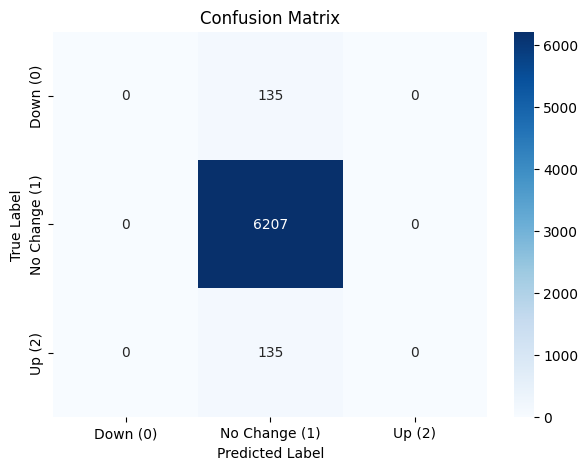

In [69]:
# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=report_labels)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=report_target_names,
            yticklabels=report_target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Unfortunately, as we can see this is a more fundamental problem and requires changes to the architecture itself. To remedy this, we can use a custom loss function that forces the classifier to notice the classes with lower frequency.

In [45]:
# Define the weighted loss function
def weighted_sparse_categorical_crossentropy(class_weights_tensor):
    """
    A weighted version of sparse_categorical_crossentropy.

    Args:
      class_weights_tensor: A Tensor of shape [num_classes] containing the weights
                           for each class.

    Returns:
      A loss function instance.
    """
    def loss(y_true, y_pred):
        unweighted_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        y_true_int = tf.cast(tf.squeeze(y_true), tf.int32)
        weights = tf.gather(class_weights_tensor, y_true_int)
        weighted_loss = unweighted_loss * weights
        return tf.reduce_mean(weighted_loss)
    loss.__name__ = 'weighted_sparse_categorical_crossentropy'
    return loss

In [46]:
nTP = len(target)

# Count class occurrences in the original target_mapped data
class_counts = Counter(target_mapped)
num_classes = len(class_counts)

# Compute class weights based on the original distribution
class_weights_dict = {cls: nTP / (num_classes * count) for cls, count in class_counts.items()}
print("Calculated class weights:", class_weights_dict)

sorted_weights = [class_weights_dict.get(i, 1.0) for i in range(num_classes)]
class_weights_tensor = tf.constant(sorted_weights, dtype=tf.float32)
print("Class weights tensor:", class_weights_tensor.numpy())

Calculated class weights: {np.int64(1): 0.36515912897822445, np.int64(2): 8.116441779110446, np.int64(0): 7.232687597417057}
Class weights tensor: [7.2326875  0.36515912 8.116442  ]


In [47]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=weighted_sparse_categorical_crossentropy(class_weights_tensor),
              metrics=['accuracy'])

In [48]:
batch_size = 128
epochs = 1000

Here I am updating the early stopping patience to account for increased epochs.

In [49]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=250,
                               mode='max',
                               restore_best_weights=True,
                               verbose=1)

print("\nStarting model training with weighted loss...")

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping],
                    verbose=2)

print("Model training finished.")


Starting model training with weighted loss...
Epoch 1/1000
203/203 - 5s - 24ms/step - accuracy: 0.4439 - loss: 1.2137 - val_accuracy: 0.0208 - val_loss: 0.7234
Epoch 2/1000
203/203 - 5s - 26ms/step - accuracy: 0.2988 - loss: 1.1837 - val_accuracy: 0.0208 - val_loss: 0.7547
Epoch 3/1000
203/203 - 4s - 22ms/step - accuracy: 0.2803 - loss: 1.1756 - val_accuracy: 0.0208 - val_loss: 0.7416
Epoch 4/1000
203/203 - 2s - 12ms/step - accuracy: 0.2987 - loss: 1.1651 - val_accuracy: 0.2824 - val_loss: 0.7014
Epoch 5/1000
203/203 - 3s - 13ms/step - accuracy: 0.3135 - loss: 1.1090 - val_accuracy: 0.4405 - val_loss: 0.6384
Epoch 6/1000
203/203 - 3s - 16ms/step - accuracy: 0.2829 - loss: 1.0139 - val_accuracy: 0.3059 - val_loss: 0.6707
Epoch 7/1000
203/203 - 5s - 22ms/step - accuracy: 0.2980 - loss: 0.9914 - val_accuracy: 0.3042 - val_loss: 0.6886
Epoch 8/1000
203/203 - 2s - 12ms/step - accuracy: 0.3197 - loss: 0.9684 - val_accuracy: 0.3871 - val_loss: 0.6554
Epoch 9/1000
203/203 - 2s - 11ms/step - a

In [50]:
print("\nEvaluating model on test data...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")


Evaluating model on test data...
Test Loss: 2.0321
Test Accuracy: 0.7383 (73.83%)


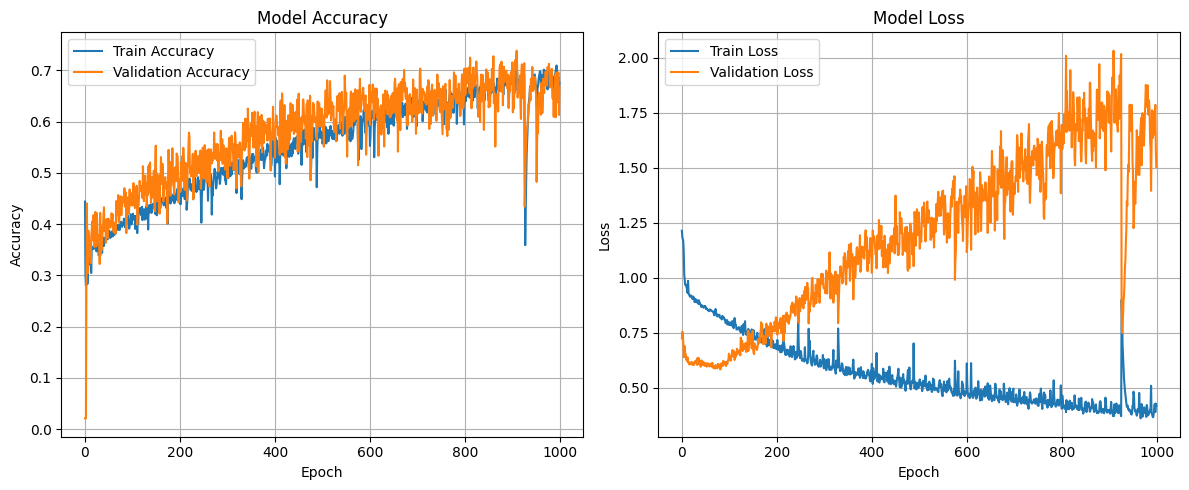

In [51]:
# Plot training history
if history and history.history:
  plt.figure(figsize=(12, 5))

  # Accuracy Plot
  plt.subplot(1, 2, 1)
  if 'accuracy' in history.history:
      plt.plot(history.history['accuracy'], label='Train Accuracy')
  if 'val_accuracy' in history.history:
      plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)

  # Loss Plot
  plt.subplot(1, 2, 2)
  if 'loss' in history.history:
    plt.plot(history.history['loss'], label='Train Loss')
  if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()
else:
  print("Could not plot training history (history object missing or empty).")

In [59]:
# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [60]:
# Classification Report
print("\nClassification Report:")
target_names = ['Down (0)', 'No Change (1)', 'Up (2)']
report_labels = np.unique(np.concatenate((y_test, y_pred)))
report_target_names = [target_names[i] for i in report_labels if i < len(target_names)]
print(classification_report(y_test, y_pred, labels=report_labels, target_names=report_target_names, zero_division=0))


Classification Report:
               precision    recall  f1-score   support

     Down (0)       0.06      0.38      0.10       135
No Change (1)       0.97      0.75      0.85      6207
       Up (2)       0.08      0.44      0.13       135

     accuracy                           0.74      6477
    macro avg       0.37      0.52      0.36      6477
 weighted avg       0.93      0.74      0.82      6477




Confusion Matrix:


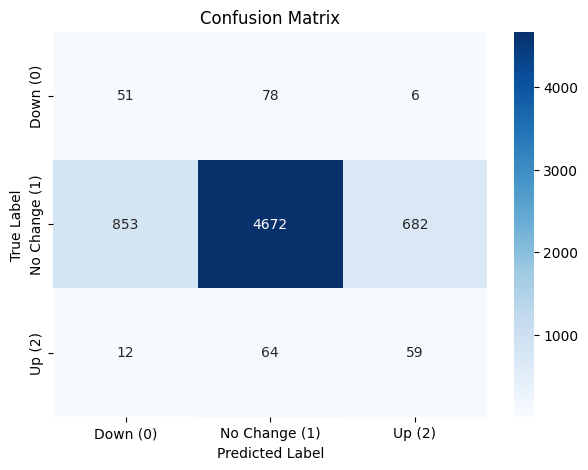

In [61]:
# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=report_labels)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=report_target_names,
            yticklabels=report_target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

We can already see from the confusion matrix that the updated loss function helped remedy the issue with the model defaulting to the majority class. Lets look at the ROC curve to get a better understanding of performance.

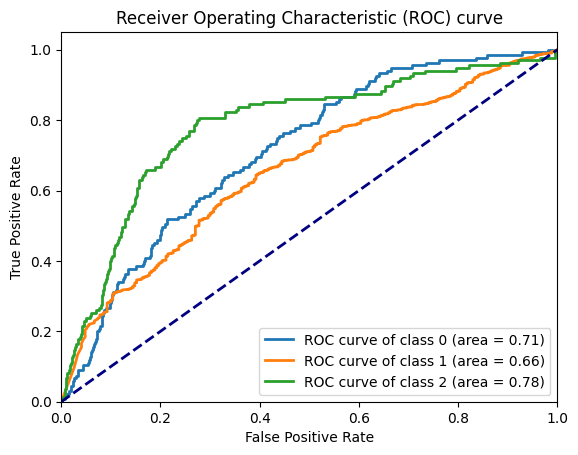

In [62]:
# Binarize the output
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure()
lw = 2
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

From the ROC curve, we can see that all of our classes show performance above the AUC=0.5 dashed line representing a random guess. The model performs best when distinguishing class 2 representing the "Up" case from classes 0 and 1. The model also shows reasonable performance at disttinguishing class 0 representing the "Down" case from classes 1 and 2. Where the model struggles is distinguishing class 1 from the other classes. This makes sense given our data and the large number of observed class 1 samples.

# Conclusion

Predicting market direction is inherently difficult. An accuracy significantly above the baseline
suggests the model has learned some predictive patterns from the chosen features and sequence length.
However, practical profitability would require further analysis including:
- Backtesting with realistic transaction costs and slippage.
- Analysis of Sharpe ratio or other risk-adjusted return metrics.
- Testing on more data (different days, different stocks).
- Additional hyperparameter tuning (seq_len, LSTM units, dropout, learning rate, dts horizon).
- Feature engineering (adding more LOB features, technical indicators, etc.).

Sources:

https://www.mathworks.com/help/deeplearning/ug/long-short-term-memory-networks.html

https://www.tensorflow.org/tutorials/structured_data/time_series

Rubisov, Anton D. "Statistical Arbitrage Using Limit Order Book Imbalance." Master's thesis, University of Toronto, 2015.